<a href="https://colab.research.google.com/github/2003UJAN/Corn_Price_Soyabean/blob/main/Corn_Prices_Soyabean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F25853%2F33055%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T183357Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3cf40abff9bdb5d337687ec9365426e42c80469abff41182aef75a04bd3e7c1a56f98acff2efbc05e4efe49d041dc77fea2bebd0c8a3dc904fd6bdc5f99b815ad774d391302853761c19cfcee5341f626cbb087dca407c0a87f5a0d4b46c6a4717e98e4bc87a7e26a25db936a8888df83e1ce5a6cb7d01bdf2d49b512c3ee3c63f71580ec54c3a5658464afe2e99fedd21cadd037d16a5b30b428b198b452250e69b79e27ed65328e01d577c7ce0a3c65eafcbbf2e7aff385ad512cd65808763f5916bf1e6c59d68c67436d24e778b6ce887f3c27673dc1af2145a371b3090c3577dbc4b966ed7c6ba1353f42a032b1b630e4f3ac07aeaa4f31cdc735b6b0a9c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 124448 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dateparse0 = lambda dates: [pd.to_datetime(d, format='%Y-%m-%d') for d in dates]
soy = pd.read_csv("../input/soybean_nearby.txt", parse_dates = ["dates"], date_parser=dateparse0)
soy.index = soy["dates"]
del soy["dates"]

def get_SupplyUse( fname_proj, MktYrs ):
    ByYear_SupplyUse = {}
    WASDE_dtstrs = []
    for mktyr in MktYrs:
        data = pd.read_csv( "../input/" + fname_proj + mktyr + ".csv" )
        data["date"] = pd.to_datetime(data["Date"])
        data.index = data['date']
        del data["date"]
        data["s2u"] = data["Ending Stocks"] / data["Total Use"]
        ByYear_SupplyUse[ mktyr ] = data
        WASDE_dtstrs = np.hstack( (WASDE_dtstrs, data["Date"].values) )
    return ByYear_SupplyUse, np.unique(WASDE_dtstrs)

SupplyUse, WASDE_dtStrs = get_SupplyUse( "USDAProj_Soybean_", ["2007to2008","2008to2009","2009to2010","2010to2011",\
                                                            "2011to2012","2012to2013","2013to2014","2014to2015",\
                                                            "2015to2016","2016to2017","2017to2018"])

<ipython-input-9-1e3ef07590c7>:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  soy = pd.read_csv("../input/soybean_nearby.txt", parse_dates = ["dates"], date_parser=dateparse0)


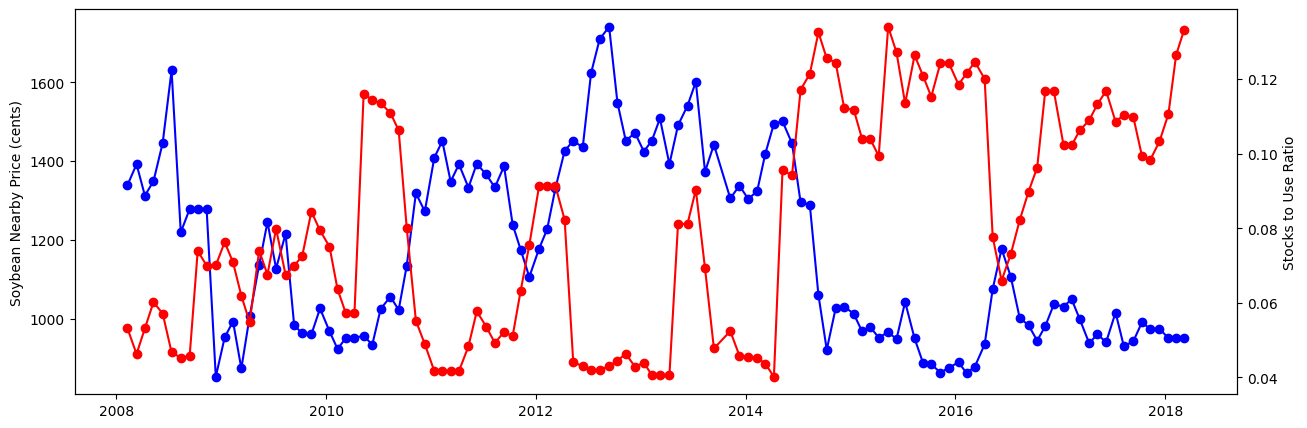

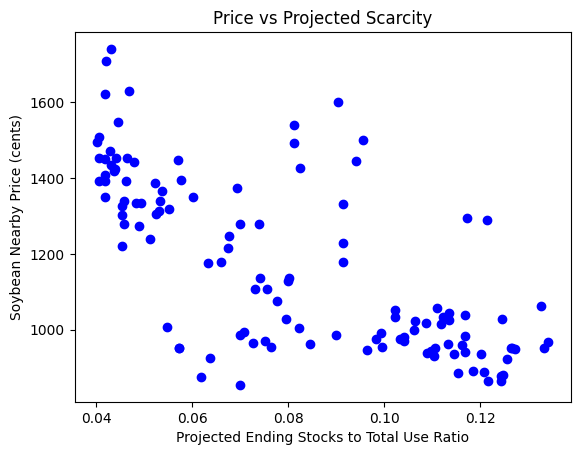

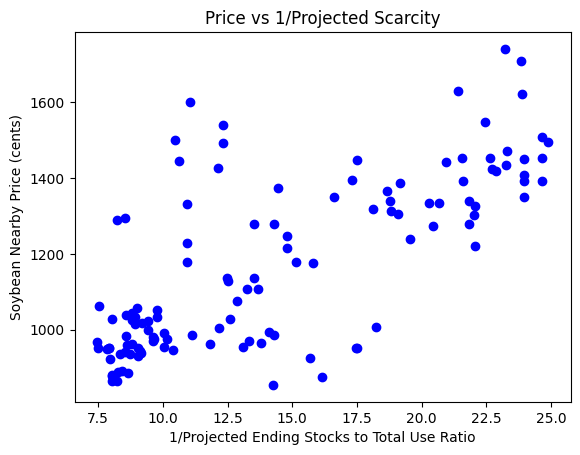

In [ ]:
def corn_soy_mktyrs( dt1 ):
    if( dt1.month < 5 ):
        NewCrop_mktyr = str( dt1.year - 1 ) + "to" + str( dt1.year )
        OldCrop_mktyr = str( dt1.year - 2 ) + "to" + str( dt1.year - 1 )
    else:
        NewCrop_mktyr = str( dt1.year ) + "to" + str( dt1.year + 1 )
        OldCrop_mktyr = str( dt1.year - 1 ) + "to" + str(dt1.year )
    return( [ NewCrop_mktyr, OldCrop_mktyr ] )

Nearby = []
S2U = []
plot_dts = []
for dtstr in WASDE_dtStrs:
    Curr_dt = datetime.strptime(dtstr, "%Y/%m/%d")
    if( Curr_dt > pd.to_datetime( soy.index[0]) ):
        new_crop_year, old_crop_year = corn_soy_mktyrs( Curr_dt )
        s2u = SupplyUse[ new_crop_year ]["s2u"][:Curr_dt][-1]
        S2U.append( s2u )
        Nearby.append( soy[:Curr_dt]["nearby_close"][-1])
        plot_dts.append( Curr_dt )

plt.subplots(figsize=(15,5))
plt.plot_date( plot_dts, Nearby, 'bo-')
plt.ylabel("Soybean Nearby Price (cents)")

ax2 = plt.twinx()
ax2.plot_date( plot_dts, S2U, 'ro-')
plt.xlabel('date')
ax2.set_ylabel("Stocks to Use Ratio")
plt.show()

InvS2U = np.divide( 1.0, np.array(S2U) )
plt.plot( S2U, Nearby, 'o', color="blue" )
plt.xlabel("Projected Ending Stocks to Total Use Ratio")
plt.ylabel("Soybean Nearby Price (cents)")
plt.title("Price vs Projected Scarcity")
plt.show()

plt.plot( InvS2U, Nearby, 'o', color="blue" )
plt.xlabel("1/Projected Ending Stocks to Total Use Ratio")
plt.ylabel("Soybean Nearby Price (cents)")
plt.title("Price vs 1/Projected Scarcity")
plt.show()

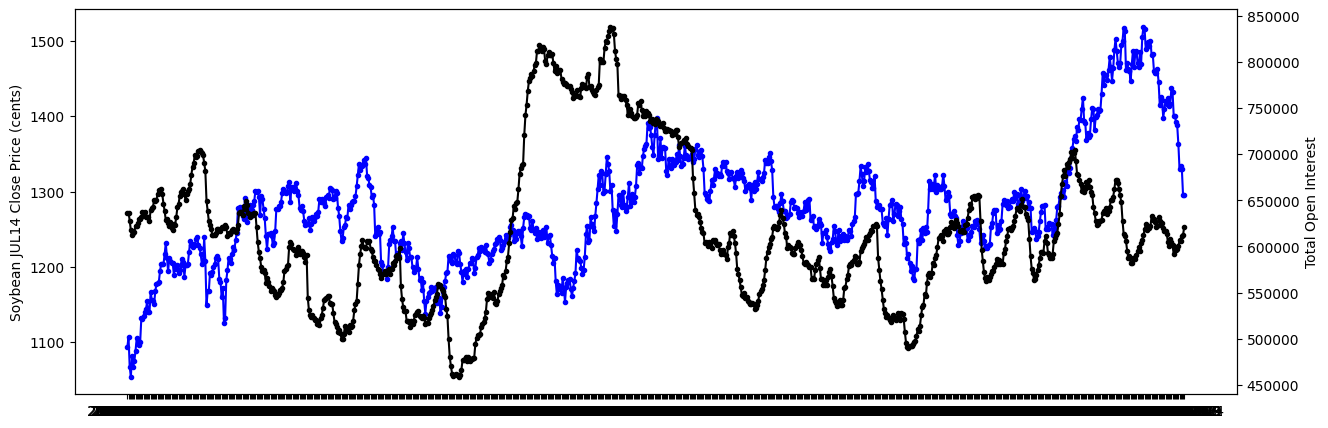

In [ ]:
soy = pd.read_csv("../input/soybean_JUL14.txt", index_col=0)
soy = soy.loc[ soy["TotalOpenInt"] != 0 ]
plt.subplots(figsize=(15,5))
plt.plot_date( soy.index, soy["Close"], '.-', color="blue")
plt.ylabel("Soybean JUL14 Close Price (cents)")
ax2 = plt.twinx()
ax2.plot_date( soy.index, soy["TotalOpenInt"], '.-', color="black")
ax2.set_ylabel("Total Open Interest")
plt.show()

In [ ]:
df = soy[["Close", "TotalOpenInt"]].copy()
spearmanWindow = 10
spearmanVec = [ None for p in range(0,spearmanWindow)]
for ii in range(10, len(df["Close"])):
    newR = stats.spearmanr( df["Close"][ ii-10: ii], df["TotalOpenInt"][ ii-10: ii])[0]
    spearmanVec.append( newR )
df["Spearman"] = spearmanVec

In [ ]:
last_S2U = []
for ii in df.index:
    Curr_dt = pd.to_datetime(ii )
    new_crop_year, old_crop_year = corn_soy_mktyrs( Curr_dt  )
    s2u_new_vals = SupplyUse[ new_crop_year ]["s2u"][:ii]
    if len(s2u_new_vals ):
        s2u = s2u_new_vals[-1]
    else:
        s2u = SupplyUse[ old_crop_year ]["s2u"][:ii][-1]
    last_S2U.append( s2u )
df["S2U"] = last_S2U
df["InvS2U"] = df["S2U"].apply( lambda x: 1.0 / float( x ) )
df = df.iloc[ spearmanWindow:, :] # need to drop the first NaN entries
df.head(5)

,Close,TotalOpenInt,Spearman,S2U,InvS2U
dates,,,,,
2010-11-29,1096.0,629228.0,0.565352,0.055207,18.113514
2010-11-30,1100.0,629641.0,0.565352,0.055207,18.113514
2010-12-01,1132.0,631521.0,0.516720,0.055207,18.113514
2010-12-02,1131.0,637044.0,0.806061,0.055207,18.113514
2010-12-03,1135.0,635581.0,0.866667,0.055207,18.113514


In [ ]:

def normalize_windows( window_data, colsToNormalize, colsNotNormalized ):
    normalized_data=[]
    normalizing_vals=[]
    for window in window_data:
        window_norm = np.empty_like(window)
        norm_vals = []
        for c in colsToNormalize:
            firstVal = float(window[0,c])
            norm_col = [ ((float(p) / firstVal ) - 1 ) for p in window[:,c]]
            window_norm[:,c] = norm_col
            norm_vals.append( firstVal )
        for cc in colsNotNormalized:
            window_norm[ :, cc ] = [ p for p in window[:,cc]]
        normalized_data.append( window_norm )
        normalizing_vals.append( norm_vals )
    return [ normalized_data, np.array(normalizing_vals) ]

def denormalize_windows( scValues, norm_values ):
    output = []
    for ii in range( scValues.shape[0]):
        scV_row = scValues[ii,:]
        norm_row = norm_values[ii]
        out_row = np.multiply( norm_row, scV_row + 1 )
        output.append( list(out_row) )
    return np.array(output )

data = df[["Close", "TotalOpenInt", "Spearman", "InvS2U"]].values
train_percent = 0.9
seq_len = 20
sequence_length = seq_len + 1
result = []
for index in range( len(data) - sequence_length):
    result.append( data[ index: index + sequence_length ])

result, norm_vals = normalize_windows( result, [0],  [1,2,3] )

In [ ]:
result = np.array( result )
row = round( train_percent * result.shape[0])

X_train = result[:int(row), :-1, 1:]
y_train = result[:int(row), -1, 0]
norm_vals_train = norm_vals[:int(row)]

X_test = result[ int(row):, :-1, 1:]
y_test = result[ int(row):, -1,  0]
norm_vals_test = norm_vals[int(row):]

scX = MinMaxScaler(feature_range=(-1,1))
dummyX = X_train.copy()
tallX = dummyX[0].copy()
for ii in range( 1, len(dummyX) ):
    tallX = np.append( tallX, dummyX[ii] , axis=0 )
scX.fit( tallX )

for ii in range( 0, len(X_train)):
    X_train[ii] = scX.transform( X_train[ii] )

for ii in range( 0, len(X_test)):
    X_test[ii] = scX.transform( X_test[ii] )

scY = MinMaxScaler()
y_train = scY.fit_transform( y_train.reshape(-1,1) )
y_test = scY.transform( y_test.reshape(-1,1) )

In [ ]:
def build_model( layers ):
    dropout = 0.2
    model = Sequential()
    model.add(LSTM(50, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(32, kernel_initializer="uniform", activation="relu"))
    model.add(Dense(1, kernel_initializer="uniform", activation="linear"))

    model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
    return model

model = build_model( [X_train.shape[1], X_train.shape[2],  1 ])

model.fit( X_train, y_train, batch_size=32, epochs=100)
y_pred = model.predict( X_test )

Epoch 1/100
25/25 [==============================] - 8s 39ms/step - loss: 0.2042 - accuracy: 0.0013
Epoch 2/100
25/25 [==============================] - 1s 44ms/step - loss: 0.0383 - accuracy: 0.0025
Epoch 3/100
25/25 [==============================] - 2s 72ms/step - loss: 0.0286 - accuracy: 0.0013
Epoch 4/100
25/25 [==============================] - 2s 81ms/step - loss: 0.0274 - accuracy: 0.0013
Epoch 5/100
25/25 [==============================] - 1s 47ms/step - loss: 0.0272 - accuracy: 0.0013
Epoch 6/100
25/25 [==============================] - 1s 42ms/step - loss: 0.0279 - accuracy: 0.0000e+00
Epoch 7/100
25/25 [==============================] - 1s 52ms/step - loss: 0.0260 - accuracy: 0.0013
Epoch 8/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0264 - accuracy: 0.0025
Epoch 9/100
25/25 [==============================] - 1s 23ms/step - loss: 0.0257 - accuracy: 0.0000e+00
Epoch 10/100
25/25 [==============================] - 1s 24ms/step - loss: 0.0262 - accuracy

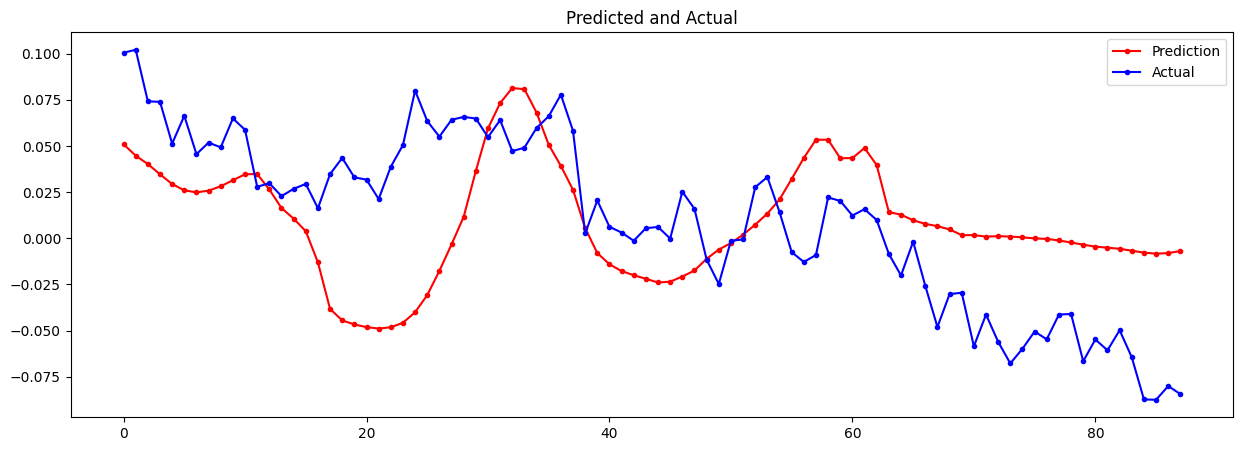

In [ ]:
invSc_YPred = scY.inverse_transform( y_pred )
invSc_Y_test = scY.inverse_transform( y_test )

plt.subplots(figsize=(15,5))
plt.plot( invSc_YPred, marker=".", color="red", label="Prediction")
plt.plot( invSc_Y_test, marker=".", color="blue", label="Actual")
plt.legend(loc="best")
plt.title("Predicted and Actual")
plt.show()

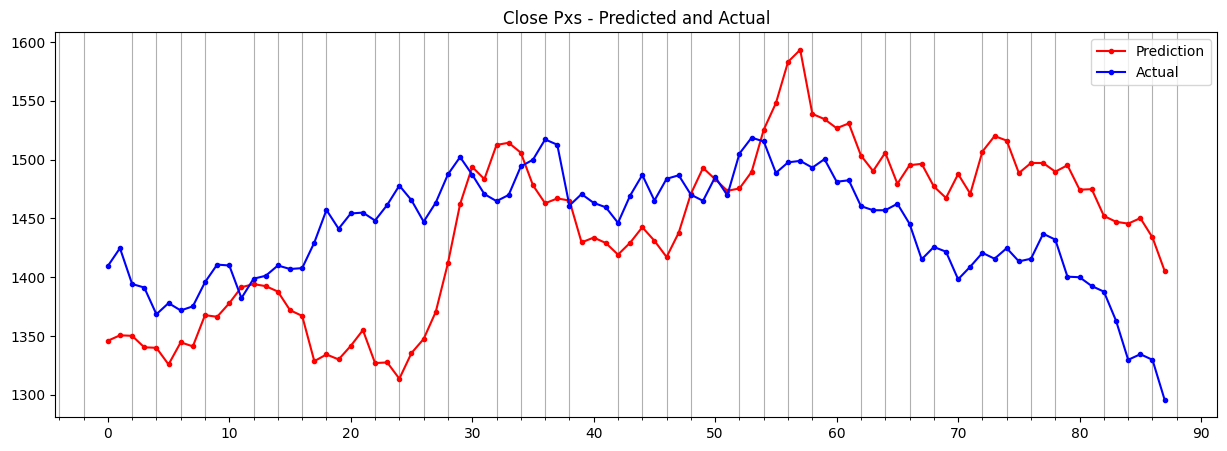

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

inv_y_test = denormalize_windows( invSc_Y_test, norm_vals_test )
inv_y_test_pred = denormalize_windows( invSc_YPred, norm_vals_test )

plt.subplots(figsize=(15,5))
plt.plot( inv_y_test_pred, marker='.', color="red", label="Prediction")
plt.plot( inv_y_test, marker='.',  color="blue", label="Actual")
plt.legend(loc="best")
plt.title("Close Pxs - Predicted and Actual")
ax = plt.gca()
majorLocator = MultipleLocator(10)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(2)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)

ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which="minor")
plt.show()